## Imports

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score,balanced_accuracy_score
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
import requests
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import dask.dataframe as dd

In [108]:
pd.set_option('display.max_rows', None)

In [109]:
df=pd.read_csv('Watches.csv')

/var/folders/5q/f280wjd15s56_y9s5ntbx3rw0000gn/T/ipykernel_24887/3990443208.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Watches.csv')


In [110]:
df.drop(columns="Unnamed: 0", inplace=True)

## Dataset Information

### Columns types

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284491 entries, 0 to 284490
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   name       211906 non-null  object
 1   price      284085 non-null  object
 2   brand      284360 non-null  object
 3   model      254025 non-null  object
 4   ref        241339 non-null  object
 5   mvmt       87806 non-null   object
 6   casem      120220 non-null  object
 7   bracem     109595 non-null  object
 8   yop        284357 non-null  object
 9   cond       208504 non-null  object
 10  sex        188686 non-null  object
 11  size       260894 non-null  object
 12  condition  71569 non-null   object
dtypes: object(13)
memory usage: 28.2+ MB


All the columns have an object format. We will need to modify it.

### NaN

In [112]:
df.isna().sum()

name          72585
price           406
brand           131
model         30466
ref           43152
mvmt         196685
casem        164271
bracem       174896
yop             134
cond          75987
sex           95805
size          23597
condition    212922
dtype: int64

All the columns contain NaN. We will deal with it later

### Check if model and ref are linked together. In that case, we should keep only one.

In [113]:
model_ref_counts = df.groupby('model')['ref'].nunique()

In [114]:
model_ref_counts

model
103                                                      16
104                                                       9
140                                                       2
142                                                       1
144                                                       4
156                                                       3
157                                                       2
1815                                                     47
1926                                                     73
1972                                                     17
2000                                                     65
203                                                       2
21 Chronoscaph                                            7
21 Must de Cartier                                       15
240                                                       2
256                                                       0
303                               

It seems every model contains many references.
For our model, we will keep only the model information, to avoid having too much information for now.

### Check type of information contained in every column

In [115]:
df['mvmt'].unique()

array([nan, 'Automatic', 'Manual winding', 'Quartz'], dtype=object)

In [116]:
df['casem'].unique()

array([nan, 'Steel', 'Titanium', 'White gold', 'Ceramic', 'Rose gold',
       'Yellow gold', 'Gold/Steel', 'Platinum', 'Carbon', 'Red gold',
       'Tantalum', 'Aluminum', 'Bronze', 'Plastic', 'Silver', 'Palladium',
       'Tungsten'], dtype=object)

In [117]:
df['bracem'].unique()

array([nan, 'Steel', 'Rubber', 'Crocodile skin', 'White gold', 'Ceramic',
       'Rose gold', 'Yellow gold', 'Titanium', 'Calf skin', 'Gold/Steel',
       'Leather', 'Platinum', 'Satin', 'Textile', 'Red gold',
       'Lizard skin', 'Plastic', 'Aluminium', 'Silicon', 'Shark skin',
       'Silver', 'Snake skin', 'Ostrich skin'], dtype=object)

In [118]:
df['cond'].unique()

array(['Unworn', 'Very good', 'New', 'Good', 'Fair', nan, 'Poor',
       'Incomplete'], dtype=object)

In [119]:
df['condition'].unique()

array([nan, 'Very good', 'Unworn', 'Good', 'Fair', 'New', 'Poor',
       'Incomplete'], dtype=object)

To sum up :
- mvmt = Type of movement
- casem = material used
- bracem = strap material
- cond = condition
- condition = condition

## Process the NaN

In [120]:
df.isna().sum()

name          72585
price           406
brand           131
model         30466
ref           43152
mvmt         196685
casem        164271
bracem       174896
yop             134
cond          75987
sex           95805
size          23597
condition    212922
dtype: int64

For different columns containing NaN values, we will refer to the other columns to fill them. 
If a column contains NaN, we will search for an associated value in other columns, which may provide similar information. 
Then, we will check if this associated value can be found in other rows and be linked to a valid value.

### Fill NaN in the mvmt column

We need NaN values to be replaced by valid values in the column mvmt. We assume that a unique value of name corresponds to a unique product. In this case, the product features should always be the same. Therefore, we start by retrieving the names of products for which the column mvmt contains at least one NaN value.

In [121]:
names=pd.DataFrame(df[df['mvmt'].isnull()]['name'])

We will now isolate those rows containing a product name for which 'mvmt' contains at least one null value into a dataframe. We select two columns: the product name and the associated 'mvmt' value.

In [122]:
filtered_mvmt = df[df['name'].isin(names['name'])][['name','mvmt']]

We remove the rows where the 'mvmt' value is NaN. We only want valid values to match our dataframe later on.

In [123]:
filtered_mvmt.dropna(subset=['mvmt'],inplace=True)

We create a new column in df. This new column provides the non-NaN values associated with each product name for which we have at least one NaN value associated in the 'mvmt' column.

In [124]:
df = pd.merge(df, filtered_mvmt, on='name', how='inner')

We fill the NaN values of mvmt with the non-NaN values corresponding to the same name.

In [125]:
df['mvmt_x']=df['mvmt_x'].fillna(df['mvmt_y'])

### Fill NaN in the casem column

In [126]:
names=pd.DataFrame(df[df['casem'].isnull()]['name'])

In [127]:
filtered_casem = df[df['name'].isin(names['name'])][['name','casem']]

In [128]:
filtered_casem.dropna(subset=['casem'],inplace=True)

In [129]:
filtered_casem = filtered_casem.drop_duplicates()

In [130]:
df = pd.merge(df, filtered_casem, on='name', how='inner')

In [131]:
df['casem_x']=df['casem_x'].fillna(df['casem_y'])

### Fill NaN in the bracem column

In [132]:
names=pd.DataFrame(df[df['bracem'].isnull()]['name'])

In [133]:
filtered_bracem = df[df['name'].isin(names['name'])][['name','bracem']]

In [134]:
filtered_bracem.dropna(subset=['bracem'],inplace=True)

In [135]:
filtered_bracem = filtered_bracem.drop_duplicates()

In [136]:
df = pd.merge(df, filtered_bracem, on='name', how='inner')

In [137]:
df['bracem_x']=df['bracem_x'].fillna(df['bracem_y'])

### Fill NaN in the cond column

In [138]:
df['cond']=df['cond'].fillna(df['condition'])

### Fill NaN in the sex column

In [139]:
names=pd.DataFrame(df[df['sex'].isnull()]['name'])

In [140]:
filtered_sex = df[df['name'].isin(names['name'])][['name','sex']]

In [141]:
filtered_sex.dropna(subset=['sex'],inplace=True)

In [142]:
filtered_sex = filtered_sex.drop_duplicates()

In [143]:
df = pd.merge(df, filtered_sex, on='name', how='inner')

In [144]:
df['sex_x']=df['sex_x'].fillna(df['sex_y'])

### Fill NaN in the size column

In [145]:
names=pd.DataFrame(df[df['size'].isnull()]['name'])

In [146]:
filtered_size = df[df['name'].isin(names['name'])][['name','size']]

In [147]:
filtered_size.dropna(subset=['size'],inplace=True)

In [148]:
filtered_size = filtered_size.drop_duplicates()

In [149]:
df = pd.merge(df, filtered_size, on='name', how='inner')

In [150]:
df['size_x']=df['size_x'].fillna(df['size_y'])

## Reordering columns

### Drop duplicates

In [151]:
df = df.drop_duplicates()

### Removing unnecessary columns

In [152]:
df = df.drop(columns=(['ref','condition','mvmt_y','casem_y','bracem_y','sex_y','size_y']))

### Rename columns to have something more accurate

In [153]:
df=df.rename(columns={'mvmt_x':'Movement','casem_x':'Material','bracem_x':'Strap Material','sex_x':'Target people','size_x':'Size'})

### Drop NaN values

In [154]:
df=df.dropna()

## Deal with special values

### In price column

We need to remove the '$' from price column.

In [155]:
df['price'] = df['price'].str.replace('$', '')

We need to replace 'Price on request' by a numerical value.

First, we need to replace 'Price on request' by 0. 'Price on request' won't be recognized by the function.

In [156]:
df.loc[df['price'] == 'Price on request', 'price'] = 0

We can now convert the prices in numerical values.

In [158]:
df['price'] = df['price'].str.replace(',', '')

df['price'] = df['price'].astype(float)

Let's calculate the mean prices of products based on their main characteristics : Type of movement, material, strap material and condtion.

In [159]:
df_no_null=df[df['price']!=0]

In [160]:
df_price_means = pd.DataFrame(df_no_null.groupby(['Movement','Material','Strap Material','cond'])['price'].mean())
df_price_means

price
Movement       Material    Strap Material cond                     
Automatic      Bronze      Calf skin      New           4727.000000
                                          Unworn        5263.000000
                                          Very good     4249.333333
                           Leather        New           6530.857143
                                          Unworn        6189.285714
                                          Very good     4520.461538
                           Rubber         New           6524.800000
                                          Unworn        6699.500000
                                          Very good     4249.333333
               Carbon      Crocodile skin Fair          2415.000000
                                          Good          5413.333333
                                          New          13631.411765
                                          Unworn        7142.600000
                                          Very good     7390.625000
                           Leather        Fair          2415.000000
                                          Good          5413.333333
                                          New          13631.411765
                                          Unworn        7142.600000
                                          Very good     7390.625000
                           Rubber         Fair          2415.000000
                                          Good          5413.333333
                                          New          13632.736842
                                          Unworn        7621.187500
                                          Very good     7702.200000
                           Textile        New          11704.000000
                                          Unworn       10765.000000
                                          Very good             NaN
                           Titanium       Fair          2415.000000
                                          Good          5413.333333
                                          New          13631.411765
                                          Unworn        7142.600000
                                          Very good     7390.625000
               Ceramic     Calf skin      Good         13017.000000
                                          New          19791.400000
                                          Unworn       17612.166667
                           Ceramic        New          15048.949398
                                          Unworn       13827.555556
                                          Very good    20664.000000
                           Crocodile skin New          12267.970588
                                          Unworn       12604.147059
                                          Very good    10160.500000
                           Gold/Steel     New          61447.500000
                                          Very good    32343.000000
                           Leather        Fair          6680.000000
                                          Good         10538.142857
                                          New          13817.781955
                                          Unworn       12066.475610
                                          Very good     9738.181818
                           Rose gold      New          61447.500000
                                          Very good    32343.000000
                           Rubber         New          13108.159624
                                          Unworn       14802.427083
                                          Very good    26544.000000
                           Steel          New          61447.500000
                                          Very good    32343.000000
                           Textile        Fair          6680.000000
                                          Good          9919.000000
                                          New     

We can now add a new column to df. It corresponds to the average price of the product based on its characteristics.

In [161]:
df = df.merge(df_price_means, how='left', on=['Movement','Material','Strap Material','cond'], suffixes=('', '_mean'))

We can replace null values of price by the mean values corresponding to its characteristics.

In [162]:
df['price'] = df['price'].fillna(df['price_mean'])

In [184]:
df.drop(columns=['price_mean'],inplace=True)

### In size column

In [168]:
df['Size'].unique()

array(['34 mm', '39 mm', '38 mm', '41 mm', '33 mm', '43 mm', '31 mm',
       '42 mm', '30 mm', '37 mm', '44 mm', '41 x 10.5 mm', '41mm mm',
       '40 mm', '45 mm', '35 mm', '36 mm', '32 mm', '44 x 48 mm',
       '39 x 40 mm', '42.5 x 56 mm', '41 x 22 mm', '4141 mm', '46 mm',
       '40.5 mm', '43mm', '42 x 48 mm', '43.7 mm', '29.5 x 22 mm',
       '41 x 31 mm', '27 x 22 mm', '33.7 x 25.5 mm', '35.1 x 41.9 mm',
       '35.1 mm', '39.8 mm', '39.8 x 40 mm', '26 mm', '25 mm', '21mm mm',
       '23,5 mm', '23.5 x 30 mm', '27 x 32 mm', '38 x 51 mm',
       '39 x 51 mm', '42 x 51 mm', '21 mm', '29 mm', '24 mm',
       '33,7 x 25,5 mm', '31 x 34 mm', '27 mm', '28 mm', '22 x 29 mm',
       '41.9 x 45.1 mm', '35,1 mm', '35,1 x 41,9 mm', '22 mm',
       '22 x 30 mm', '25.5 mm', '23 mm', '20 x 28 mm', '27 x 20 mm',
       '23 x 23,5 mm', '23 x 30 mm', '25 x 34 mm', '25.5 x 33.7 mm',
       '24 x 30 mm', '25 x 33 mm', '25 x 20 mm', '20 mm', '38.00 mm',
       '33.00 mm', '39,7 mm', '40 x 46 mm', '

We need to replace all the lines containing comments from the retailer, and keep only the mentioned diameter.

In [165]:
df.loc[df['Size'].str.contains('No chips or cracks, very clean condition'), 'Size'] = '43mm'

In [166]:
df.loc[df['Size'].str.contains('main body case, but it is in a beautiful state overall'), 'Size'] = '40.4 mm'

In [167]:
df.loc[df['Size'].str.contains('Smooth satin-brushed steel bezel'), 'Size'] = '39mm'

### In yop column

Some years contain 'Approximation', which has to be removed.

In [169]:
df['yop'] = df['yop'].str.replace('(Approximation)', '')

Some years are 'Unknown', which has to be replaced by the mean year of products with the same characteristics.

In [170]:
df_no_null=df[df['yop']!='Unknown']

df_no_null.loc[:, 'yop'] = df_no_null['yop'].astype('float')

In [173]:
df_year_means = pd.DataFrame(df_no_null.groupby(['name', 'Movement', 'Material', 'Strap Material'])['yop'].mean().round(0))
df_year_means

,,,,yop
name,Movement,Material,Strap Material,
A. Lange & Söhne 1815\nRattrapante Perpetual Calendar,Manual winding,Platinum,Crocodile skin,2017.666667
A. Lange & Söhne Cabaret\n107.021,Manual winding,Yellow gold,Leather,2009.0
A. Lange & Söhne Lange 1\n160.029,Manual winding,White gold,White gold,2002.5
Audemars Piguet Huitième\n14593ST,Automatic,Steel,Leather,1988.5
Audemars Piguet Royal Oak\n15510BC.OO.1320BC.02,Automatic,Steel,Steel,2023.0
Audemars Piguet Royal Oak\n15510OR.OO.1320OR.04,Automatic,Rose gold,Rose gold,2022.666667
Audemars Piguet Royal Oak\n15510OR.OO.D002CR.02,Automatic,Rose gold,Crocodile skin,2022.75
Audemars Piguet Royal Oak\n15510ST.OO.1320ST.07,Automatic,Steel,Steel,2023.0
Audemars Piguet Royal Oak\n15551ST.ZZ.1356ST.06,Automatic,Steel,Steel,2023.0


In [174]:
df = df.merge(df_year_means, how='left', on=['name','Movement','Material','Strap Material'], suffixes=('', '_mean'))

In [175]:
df.loc[df['yop'] == 'Unknown', 'yop'] = df['yop_mean'].round(0)

We drop the remaining NaN.

In [182]:
df.dropna(subset=['yop'],inplace=True)

We do not the 'yop_mean' column anymore.

In [186]:
df.drop(columns=['yop_mean'],inplace=True)

A year should be in integer format.

In [189]:
df['yop'] = df['yop'].astype(int)
df['yop'] = df['yop'].round(decimals=0)

## Prepare df for the model

### Drop duplicates

In [195]:
df = df.drop_duplicates()

### Drop NaN

In [196]:
df = df.dropna()

### Convert string into categories

In [199]:
string = ['name','brand','model','Movement','Material','Strap Material','cond','Target people','Size']

In [200]:
for col in df.columns:
    if col in string:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])

## Correlation matrix

In [206]:
correlation_matrix = df.corr()

In [209]:
correlation_matrix

,name,price,brand,model,Movement,Material,Strap Material,yop,cond,Target people,Size
name,1.000000,0.053137,0.968598,-0.187040,-0.057179,0.109601,0.161520,-0.024342,0.091926,-0.138965,0.206931
price,0.053137,1.000000,0.039265,0.064237,-0.084138,0.002650,0.022627,0.036485,0.031663,-0.100477,0.143210
brand,0.968598,0.039265,1.000000,-0.297820,-0.039680,0.098135,0.123125,-0.015668,0.104081,-0.116339,0.162620
model,-0.187040,0.064237,-0.297820,1.000000,0.093075,0.051706,-0.047968,-0.086277,-0.066631,-0.122076,-0.026634
Movement,-0.057179,-0.084138,-0.039680,0.093075,1.000000,0.014173,-0.047606,-0.024890,0.047477,0.106984,-0.218060
Material,0.109601,0.002650,0.098135,0.051706,0.014173,1.000000,0.099620,-0.069373,-0.002767,-0.046701,0.033862
Strap Material,0.161520,0.022627,0.123125,-0.047968,-0.047606,0.099620,1.000000,-0.021174,-0.052728,-0.074833,0.193343
yop,-0.024342,0.036485,-0.015668,-0.086277,-0.024890,-0.069373,-0.021174,1.000000,0.172266,0.054490,0.116117
cond,0.091926,0.031663,0.104081,-0.066631,0.047477,-0.002767,-0.052728,0.172266,1.000000,-0.019957,0.027186
Target people,-0.138965,-0.100477,-0.116339,-0.122076,0.106984,-0.046701,-0.074833,0.054490,-0.019957,1.000000,-0.455039


<Axes: >

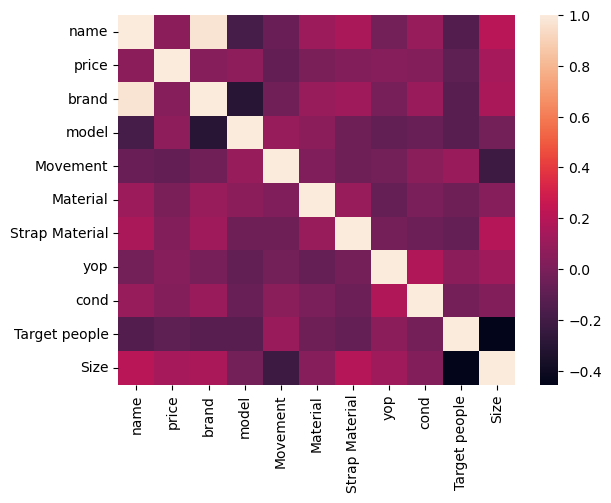

In [208]:
sns.heatmap(correlation_matrix)

In [ ]:
Name and brand are highly correlated. We drop 